In [116]:
import sys
import numpy as np
import pandas as pd
from fingerprints.get_fp import output, input
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
%matplotlib inline

from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn import utils


In [146]:
labels_kmeans = pd.read_csv('data/labels_kmeans.csv') # .set_index('CID') commented so X and Y later have same indices
labels_hrc = pd.read_csv('data/labels_hrc.csv').set_index('CID')

kmeans_counts = labels_kmeans.sum().sort_values(ascending=False)
manual_counts = labels_manual.sum().sort_values(ascending=False)
hierarchical_counts = labels_hrc.sum().sort_values(ascending=False)

print(kmeans_counts, hierarchical_counts, manual_counts)

fingerprint = input

CID          24234111917
cluster_3           2840
cluster_7           1377
cluster_0           1161
cluster_5            896
cluster_8            821
cluster_1            767
cluster_4            551
cluster_6            403
cluster_2            399
dtype: int64 cluster_3    2840
cluster_7    1377
cluster_0    1161
cluster_5     896
cluster_8     821
cluster_1     767
cluster_4     551
cluster_6     403
cluster_2     399
dtype: int64 fruity        1736
general       1287
spices        1189
sweet         1170
savoury       1136
green         1101
earthy        1050
sharp          635
artificial     247
dtype: int64


In [138]:
from sklearn.model_selection import StratifiedKFold

def kfold_cv(X, y, k, H, cv_fun, random_state):
    """
    Do stratified k-fold cross-validation with a dataset, to check how a model behaves as a function
    of the values in H (eg. a hyperparameter such as tree depth, or polynomial degree).

    :param X: feature matrix.
    :param y: response column.
    :param k: number of folds.
    :param H: values of the hyperparameter to cross-validate.
    :param cv_fun: function of the form (X_train, y_train, X_valid, y_valid, h) to evaluate the model in one split,
        as a function of h. It must return a dictionary with metric score values.
    :param random_state: controls the pseudo random number generation for splitting the data.
    :return: a Pandas dataframe with metric scores along values in H.
    """
    kf = StratifiedKFold(n_splits = k, shuffle = True, random_state = random_state)
    scores = []  # to store global results

    # for each value h in H, do CV
    for h in H:
        
        # for each fold 1..K
        kk = 0
        for train_index, valid_index in kf.split(X, y):
            kk = kk+1
            # partition the data in training and validation
            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

            # call cv_fun to train the model and compute performance
            fold_scores = {'_h': h, '_fold': kk}
            fold_scores.update(cv_fun(X_train, y_train, X_valid, y_valid, h))
            scores.append(fold_scores)
            
    return pd.DataFrame(scores)

## kmeans

In [164]:
labels_kmeans = labels_kmeans.drop(labels="CID",axis="columns")
labels_kmeans

KeyError: "['CID'] not found in axis"

# Splitting the data per cluster
To split the data, we're going to do the test split for each cluster separately and add it together, then shuffle.

In [211]:
y = labels_kmeans
X = fingerprint

# create lists for the training and test set indices
train_indx = set()
test_indx = set()

# loop over all clusters in y and get the train and test indices
# TODO maybe just create the test split and have that be 20% total and taking the rest as the training set??
# So check the percentage of values in each cluster and have the test sets be built up in that ratio too? 
# So having a different test size for different clusters??
for cluster in y.columns:
    cluster_indx = []
    for i in y.index:
        if y.loc[i,cluster] == 1:
            cluster_indx.append(i)
    # create training and test split for the cluster
    train_cluster_indx, test_cluster_indx = train_test_split(cluster_indx, test_size = 0.2, random_state = 12345)
    # check if the indices are already in the other set
    for idx in train_cluster_indx:
        if idx in test_indx or idx in test_cluster_indx:
            train_cluster_indx.remove(idx)
    for idx in test_cluster_indx:
        if idx in train_indx or idx in train_cluster_indx:
            test_cluster_indx.remove(idx)
    # update the training and test indices
    train_indx.update(train_cluster_indx)
    test_indx.update(test_cluster_indx)

# shuffle indices after all cluster indices were added
shuff_train_indx = utils.shuffle(list(train_indx))
shuff_test_indx = utils.shuffle(list(test_indx))

# Get the training and test sets for X and y
y_train = y.iloc[shuff_train_indx,]
y_test = y.iloc[shuff_test_indx,]
X_train = X[shuff_train_indx,]
X_test = X[shuff_test_indx,]

print(f"training set is {len(y_train)} items long and the test set is {len(y_test)} items long")

duplicates = train_indx.intersection(test_indx)
print(len(duplicates))

# The original k-means train_test_split:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

training set is 2929 items long and the test set is 1030 items long
472


# Some duplicate indices in the training and test sets, what to do with those?
There are 472 indexes that are present in both, should they then just be removed from the  test set? 
Doing this gives us a test set that's about 16% of the original data and a training set of 84%.
Idk how sound this is from a methods point of view, but using a test size of 25% and then substracting the duplicates gives us a final test set of 19%. There should be a way to solve the duplicates though I think?

In [6]:
m_rf = RandomForestClassifier(n_estimators = 10, max_features = 3)
multi_target_rf = MultiOutputClassifier(m_rf).fit(X_train, y_train)
y_pred = multi_target_rf.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred), "\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.23638968481375358 

              precision    recall  f1-score   support

           0       0.77      0.54      0.63       244
           1       0.81      0.47      0.60       150
           2       0.53      0.11      0.18        76
           3       0.82      0.94      0.87       562
           4       0.53      0.25      0.34       106
           5       0.68      0.32      0.44       177
           6       0.56      0.45      0.50        76
           7       0.83      0.58      0.68       292
           8       0.44      0.22      0.29       148

   micro avg       0.76      0.58      0.66      1831
   macro avg       0.66      0.43      0.50      1831
weighted avg       0.73      0.58      0.62      1831
 samples avg       0.80      0.64      0.67      1831



C:\Users\jazzs\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


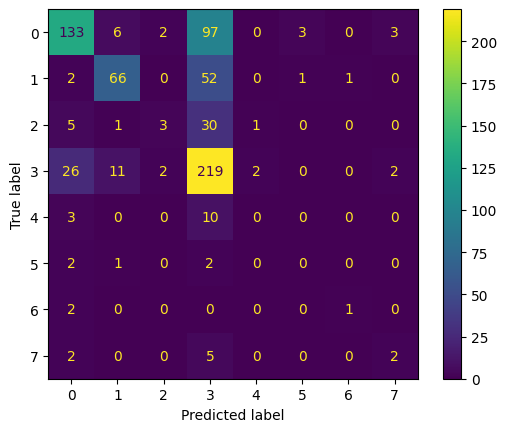

In [7]:
ConfusionMatrixDisplay.from_predictions(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))

## manual

In [8]:
y = labels_manual
X = fingerprint

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

In [9]:
m_rf = RandomForestClassifier(n_estimators = 10, max_features = 3).fit(X_train, y_train)
multi_target_rf = MultiOutputClassifier(m_rf).fit(X_train, y_train)
y_pred = multi_target_rf.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred), "\n")
print(classification_report(y_test, y_pred))

print(y_pred)


Accuracy: 0.11031518624641834 

              precision    recall  f1-score   support

           0       0.85      0.69      0.77       363
           1       0.47      0.31      0.37       206
           2       0.69      0.40      0.51       219
           3       0.60      0.33      0.43       202
           4       0.68      0.49      0.57       218
           5       0.69      0.47      0.56       249
           6       0.43      0.11      0.17        55
           7       0.55      0.25      0.35       126
           8       0.59      0.36      0.45       275

   micro avg       0.67      0.44      0.53      1913
   macro avg       0.62      0.38      0.46      1913
weighted avg       0.66      0.44      0.52      1913
 samples avg       0.61      0.46      0.49      1913

[[1 0 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]]


C:\Users\jazzs\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


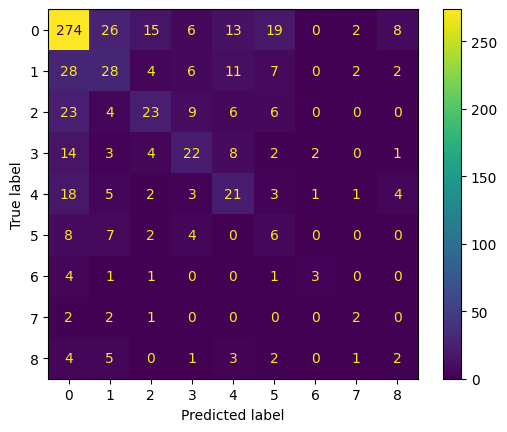

In [10]:
ConfusionMatrixDisplay.from_predictions(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))

## hrc

In [11]:
y = labels_hrc
X = fingerprint

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)


In [12]:
m_rf = RandomForestClassifier(n_estimators = 10, max_features = 3).fit(X_train, y_train)
multi_target_rf = MultiOutputClassifier(m_rf).fit(X_train, y_train)
y_pred = multi_target_rf.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred), "\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.20916905444126074 

              precision    recall  f1-score   support

           0       0.73      0.52      0.60       244
           1       0.72      0.40      0.52       150
           2       0.41      0.09      0.15        76
           3       0.83      0.92      0.87       562
           4       0.59      0.25      0.35       106
           5       0.67      0.32      0.43       177
           6       0.47      0.39      0.43        76
           7       0.81      0.55      0.66       292
           8       0.46      0.20      0.27       148

   micro avg       0.75      0.55      0.64      1831
   macro avg       0.63      0.40      0.48      1831
weighted avg       0.71      0.55      0.60      1831
 samples avg       0.78      0.61      0.64      1831



C:\Users\jazzs\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


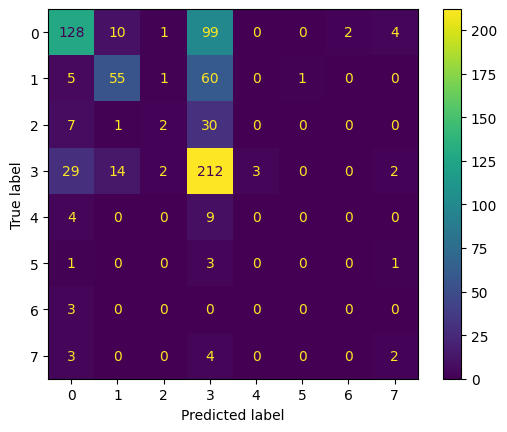

In [13]:
ConfusionMatrixDisplay.from_predictions(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))